In [1]:
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

from matplotlib import pyplot as plt

SEED = 923984

# Activation function

In [2]:
from reservoir.activation_functions import tanh, heaviside, sigmoid

# activation_function = lambda x : sigmoid(2*(x-0.5))tanh(x)
activation_function = lambda x : tanh(x)

# Loading and Preprocessing

Lots of different on availabale : https://towardsdatascience.com/a-data-lakes-worth-of-audio-datasets-b45b88cd4ad

Regression : http://tseregression.org/ + https://arxiv.org/pdf/2012.02974

Prediction Datasets available :

* MackeyGlass
* Lorenz
* Sunspot

Classification Datasets available :

* Custom :  FSDD, HAART, JapaneseVowels
* Aeon : SpokenArabicDigits, CatsDogs, LSST
* Torchaudio: SPEECHCOMMANDS

More on https://www.timeseriesclassification.com/dataset.php or https://pytorch.org/audio/stable/datasets.html

In [3]:
import math
from datasets.load_forecasting import load_dataset_forecasting
from datasets.load_classification import load_dataset_classification

# Cross validation
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit, StratifiedGroupKFold
from datasets.preprocessing import flexible_indexing

#Preprocessing
from datasets.multivariate_generation import generate_multivariate_dataset, extract_peak_frequencies
from sklearn.preprocessing import MinMaxScaler
from datasets.preprocessing import scale_data
from datasets.preprocessing import add_noise, duplicate_data

# Define noise parameter
noise_std = 0.001

data_type = "normal" # "normal" ou "noisy"

def load_data(dataset_name, data_type, noise_std, step_ahead=5, visualize=False):
    if dataset_name in ["Lorenz", "MackeyGlass", "Sunspot"]:
        is_instances_classification = False
        is_multivariate, sampling_rate, X_train_raw, X_test_raw, Y_train_raw, Y_test = load_dataset_forecasting(dataset_name, step_ahead, visualize=visualize)
        use_spectral_representation = False
        spectral_representation = None # Can be None, "stft" or "mfcc"
    elif dataset_name in ["CatsDogs", "FSDD", "JapaneseVowels", "SPEECHCOMMANDS", "SpokenArabicDigits"]:
        is_instances_classification = True
        spectral_representation = "mfcc"  # Can be None, "stft" or "mfcc"
        
        use_spectral_representation, is_multivariate, sampling_rate, X_train_raw, X_test_raw, Y_train_raw, Y_test, groups = load_dataset_classification(dataset_name, visualize=visualize)
    else:
        raise ValueError(f"Invalid dataset name: {dataset_name}")

    
    
    WINDOW_LENGTH = 10
    freq_train_data = X_train_raw
    flat_train_data = np.concatenate(freq_train_data, axis=0) if is_instances_classification else freq_train_data
    extract_peak_frequencies(flat_train_data, sampling_rate, smooth=True, window_length=WINDOW_LENGTH, threshold=1e-5, nperseg=1024, visualize=False)
    
    if is_multivariate:
        X_train_band, X_test_band = X_train_raw, X_test_raw
        del X_train_raw, X_test_raw
        X_val_band = None
    else:
        X_test, X_train = X_test_raw, X_train_raw
        X_val, X_val_band = None, None
        del X_train_raw, X_test_raw
    Y_train = Y_train_raw
    del Y_train_raw
            
    # PREPROCESSING    
    freq_train_data = X_train_band if is_multivariate else X_train
    flat_train_data = np.concatenate(freq_train_data, axis=0) if is_instances_classification else freq_train_data
    peak_freqs = extract_peak_frequencies(flat_train_data, sampling_rate, smooth=True, window_length=WINDOW_LENGTH, threshold=1e-5, nperseg=1024, visualize=False)
    
    
    if not is_multivariate:
        X_train_band = generate_multivariate_dataset(
            X_train, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
        )
        
        X_test_band = generate_multivariate_dataset(
            X_test, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
        )
    elif not use_spectral_representation:
        X_train_band = generate_multivariate_dataset(
            X_train_band, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
        )
        X_test_band = generate_multivariate_dataset(
            X_test_band, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
        )
    else:
        print("Data is already spectral and multivariate, nothing to do")
        
    scaler_multi = MinMaxScaler(feature_range=(0, 1))
    X_train_band, X_val_band, X_test_band = scale_data(X_train_band, X_val_band, X_test_band, scaler_multi, is_instances_classification)
                
    if not is_multivariate:
        scaler_x_uni = MinMaxScaler(feature_range=(0, 1))
        X_train, X_val, X_test = scale_data(X_train, X_val, X_test, scaler_multi, is_instances_classification)       
    
    # NOISE
    if data_type == "noisy":
        if is_instances_classification:
            # UNI
            if not is_multivariate:
                X_train_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_train, desc="TRAIN")]
                X_test_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_test, desc="TEST")]
                
            # MULTI
            X_train_band_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_train_band, desc="TRAIN")]
            X_test_band_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_test_band, desc="TEST")]
        
        else:  #if prediction
            # UNI
            if not is_multivariate:
                X_train_noisy = add_noise(X_train, noise_std)
                X_test_noisy = add_noise(X_test, noise_std)
        
            # MULTI
            X_train_band_noisy = add_noise(X_train_band, noise_std)
            X_test_band_noisy = add_noise(X_test_band, noise_std)
    
    # Define the number of instances you want to select
    # Define the number of instances you want to select
    x_size = len(X_train_band) if is_multivariate else len(X_train)
    num_samples_for_pretrain = 500 if x_size >= 500 else x_size
    if is_instances_classification:
        indices = np.random.choice(x_size, num_samples_for_pretrain, replace=False)
    else:
        indices = range(x_size)
    
    
    if data_type == "noisy":
        # Defining pretrain   
        if not is_multivariate:
            X_pretrain_noisy = np.array(X_train_noisy, dtype=object)[indices].flatten()
        X_pretrain_band_noisy = np.array(X_train_band_noisy, dtype=object)[indices]
    
    if not is_multivariate:
        X_pretrain = np.array(X_train, dtype=object)[indices].flatten()
    X_pretrain_band = np.array(X_train_band, dtype=object)[indices]

    return X_pretrain_band, X_train_band, X_test_band, Y_train, Y_test, is_multivariate, is_instances_classification

# Evaluation function

In [ ]:
from scipy import sparse, stats
from numpy import random
import os

#Pretraining
from reservoir.reservoir import init_matrices
from connexion_generation.hag import run_algorithm

# Evaluating
from performances.esn_model_evaluation import train_model_for_classification, predict_model_for_classification, compute_score
from performances.esn_model_evaluation import train_model_for_prediction, init_nvar_model, init_reservoir_model, init_ip_reservoir_model
from analysis.richness import spectral_radius, pearson, squared_uncoupled_dynamics_alternative, condition_number

import optuna
from performances.utility import camel_to_snake, retrieve_best_model


def evaluate_dataset_on_test(study, function_name, pretrain_data, train_data, test_data, Y_train, Y_test, is_instances_classification, nb_trials = 8, record_metrics=False):
    # Collect all hyperparameters in a dictionary
    hyperparams = {param_name: param_value for param_name, param_value in study.best_trial.params.items()}
    print(hyperparams)
    if function_name != "nvar":
        leaky_rate = 1
        input_connectivity = 1

    if 'variance_target' not in hyperparams and 'min_variance' in hyperparams:
        hyperparams['variance_target'] = hyperparams['min_variance']
    if not is_instances_classification:
        hyperparams['use_full_instance'] = False

    nb_jobs = 8


    RIDGE_COEF = 10**hyperparams['ridge']
    
    if function_name in ["hadsp", "desp"]:
        MAX_TIME_INCREMENT = hyperparams['time_increment'] + hyperparams['time_increment_span'] #int(max_window_size) or None or TIME_INCREMENT
    
    scores = [] 
    if record_metrics:
        spectral_radii = []
        pearson_correlations = []
        CEVs = []
        CNs = []
    for i in range(nb_trials):
        common_index = 1
        if is_instances_classification:
            common_size = pretrain_data[0].shape[common_index]
        else:
            common_size = pretrain_data.shape[common_index]

        # We want the size of the reservoir to be at least network_size
        K = math.ceil(hyperparams['network_size'] / common_size)
        n = common_size * K
    
        # UNSUPERVISED PRETRAINING 
        if function_name == "random_ei":
            Win, W, bias = init_matrices(n, input_connectivity, hyperparams['connectivity'],  K, w_distribution=stats.uniform(-1, 1), seed=random.randint(0, 1000))
            bias *= hyperparams['bias_scaling']
            Win *= hyperparams['input_scaling']
        elif function_name == "nvar":
            pass
        else:
            Win, W, bias = init_matrices(n, input_connectivity, hyperparams['connectivity'] ,  K, seed=random.randint(0, 1000))
            bias *= hyperparams['bias_scaling']
            Win *= hyperparams['input_scaling']

        if function_name == "hadsp":
            W, (_, _, _) = run_algorithm(W, Win, bias, hyperparams['leaky_rate'], activation_function, pretrain_data, hyperparams['time_increment'], hyperparams['weight_increment'],
                                     hyperparams['target_rate'], hyperparams['rate_spread'], function_name, is_instance=is_instances_classification, use_full_instance=hyperparams['use_full_instance'],
                                     max_increment=MAX_TIME_INCREMENT, max_partners=hyperparams['max_partners'], method=hyperparams['method'], n_jobs=nb_jobs)
        elif function_name == "desp":
            W, (_, _, _) = run_algorithm(W, Win, bias, hyperparams['leaky_rate'], activation_function, pretrain_data, hyperparams['time_increment'], hyperparams['weight_increment'],
                                    hyperparams['variance_target'], hyperparams['variance_spread'], function_name, is_instance=is_instances_classification, 
                                    use_full_instance = hyperparams['use_full_instance'], max_increment=MAX_TIME_INCREMENT, max_partners=hyperparams['max_partners'], method = hyperparams['method'], 
                                    intrinsic_saturation=hyperparams['intrinsic_saturation'], intrinsic_coef=hyperparams['intrinsic_coef'], n_jobs = nb_jobs)
        elif function_name in ["random", "random_ei", "ip"]:
            eigen = sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol=0.1, return_eigenvectors=False)
            W *= hyperparams['spectral_radius'] / max(abs(eigen))
        elif function_name == "nvar":
            pass
        else:
            raise ValueError(f"Invalid function: {function_name}")
        

        # TRAINING and EVALUATION
        if function_name == "nvar":
            reservoir, readout = init_nvar_model(delay, order, strides, ridge_coef=RIDGE_COEF)
        elif function_name == "ip":
            reservoir, readout = init_ip_reservoir_model(W, Win, bias, hyperparams['mu'], hyperparams['sigma'], hyperparams['leaky_rate'], activation_function, ridge_coef=RIDGE_COEF)
        else:
            reservoir, readout = init_reservoir_model(W, Win, bias, hyperparams['leaky_rate'], activation_function, ridge_coef=RIDGE_COEF)

        if is_instances_classification:
            mode = "sequence-to-vector"
            train_model_for_classification(reservoir, readout, train_data, Y_train, n_jobs = nb_jobs, mode=mode)

            Y_pred = predict_model_for_classification(reservoir, readout, test_data, n_jobs = nb_jobs, mode=mode)
            score = compute_score(Y_pred, Y_test, is_instances_classification)
        else:
            esn = train_model_for_prediction(reservoir, readout, train_data, Y_train)
            
            Y_pred =  esn.run(test_data, reset=False)
            score = compute_score(Y_pred, Y_test, is_instances_classification)

        scores.append(score)
        if record_metrics:
            states_history_multi = []
            neurons_state = np.random.uniform(0, 1, bias.size)
            inputs = np.concatenate(test_data, axis=0) if is_instances_classification else test_data
            states_history_multi = reservoir.run(inputs)
            
            sr = spectral_radius(W)
            pearson_correlation, _ = pearson(states_history_multi, num_windows=1, size_window=len(states_history_multi), step_size = 1, show_progress=True)
            CEV = squared_uncoupled_dynamics_alternative(states_history_multi, num_windows=1, size_window=len(states_history_multi), step_size = 1, show_progress=True)

            spectral_radii.append(sr)
            pearson_correlations.append(pearson_correlation[0])
            CEVs.append(CEV[0])
            #CNs.append(CN[0])

    if record_metrics:
        return scores, spectral_radii, pearson_correlations, CEVs
    return scores


# Test scores

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime

# Create an empty DataFrame to store the results
columns = ['Dataset', 'Function', 'Average Score', 'Standard Deviation', 'Date']
new_results = pd.DataFrame(columns=columns)

variate_type = "multi"  # "multi" or "uni"

dataset_name =  "SPEECHCOMMANDS"
pretrain_data, train_data, test_data, Y_train, Y_test, is_multivariate, is_instances_classification = load_data(dataset_name, data_type, noise_std, visualize=True)


if is_instances_classification:
    file_name = "outputs/test_results_classification.csv"
else: 
    file_name = "outputs/test_results_prediction.csv"
    
# Simulate your data and loop for evaluation
print(dataset_name)
for function_name in ["ip"]: # "desp", "hadsp", "random", "random_ei", 
    print(function_name)
    study = retrieve_best_model(function_name, dataset_name, is_multivariate, variate_type = "multi", data_type = "normal")

    scores = evaluate_dataset_on_test(
        study, 
        function_name, 
        pretrain_data, 
        train_data, 
        test_data,
        Y_train, 
        Y_test,
        is_instances_classification,
        record_metrics=False
    )
    # Compute the average and standard deviation of the scores
    average_score = np.mean(scores)
    std_deviation = np.std(scores)

    if is_instances_classification:
        formatted_average = f"{round(average_score * 100, 5)} %"
        formatted_std = f"± {round(std_deviation * 100, 5)} %"
    else:
        formatted_average = f"{round(average_score, 5)}"
        formatted_std = f"± {round(std_deviation, 5)}"
    
    # Capture the current date
    current_date = datetime.now().strftime('%Y-%m-%d')
    
    # Create a new DataFrame row with the Date column
    new_row = pd.DataFrame({
        'Dataset': [dataset_name],
        'Function': [function_name],
        'Average Score': [formatted_average],
        'Standard Deviation': [formatted_std],
        'Date': [current_date]
    })
    
    # Concatenate the new row to the results DataFrame
    new_results = pd.concat([new_results, new_row], ignore_index=True)


# Display the DataFrame
print(new_results)

# Load the existing CSV
if os.path.exists(file_name):
    previous_results = pd.read_csv(file_name)
else:
    columns = ['Dataset', 'Function', 'Average Score', 'Standard Deviation', 'Date']
    previous_results = pd.DataFrame(columns=columns)
    previous_results.to_csv(file_name, index=False)
    print(f"{file_name} created successfully.")
    
tots_results = pd.concat([new_results, previous_results], axis=0)

tots_results.to_csv(file_name, index=False)
print("Results saved to 'pipeline_results.csv'.")

## Visualisation

In [ ]:
import os
import pandas as pd 

if 'file_name' not in locals() and 'file_name' not in globals():
    file_name = "outputs/test_results_classification.csv"  #  test_results_classification.csv or test_results_prediction.csv


if os.path.exists(file_name):
    previous_results = pd.read_csv(file_name)
else:
    # File does not exist, create it with the necessary columns
    columns = ['Dataset', 'Function', 'Average Score', 'Standard Deviation', 'Date']
    previous_results = pd.DataFrame(columns=columns)
    # Save the empty DataFrame as a CSV
    previous_results.to_csv(file_name, index=False)
    print(f"{file_name} created successfully.")

print(previous_results)
print("Results saved to 'pipeline_results.csv'.")

In [ ]:
from seaborn import heatmap, color_palette
from matplotlib import pyplot as plt
import numpy as np

all_results = pd.read_csv(file_name)

df = pd.DataFrame(all_results)
# Clean 'Average Score' and 'Standard Deviation' column (remove '±' and '%' and convert to float)
df['Average Score'] = df['Average Score'].astype(str).str.replace('%', '').astype(float)
df['Standard Deviation'] = df['Standard Deviation'].str.replace('±', '').str.replace('%', '').astype(float)
df['Function'] = df['Function'].str.replace('desp', 'variance HAG')
df['Function'] = df['Function'].str.replace('hadsp', 'mean HAG')
df['Function'] = df['Function'].str.replace('random', 'E-ESN')
df['Function'] = df['Function'].str.replace('random_ei', 'ESN')

if file_name == "test_results_classification.csv":
    df['Dataset'] = df['Dataset'].str.replace('SpokenArabicDigits', 'Spoken\nArabic\nDigits')
    df['Dataset'] = df['Dataset'].str.replace('SPEECHCOMMANDS', 'SPEECH\nCOMMANDS')
    df['Dataset'] = df['Dataset'].str.replace('JapaneseVowels', 'Japanese\nVowels')

fig, ax = plt.subplots(figsize=(10, 6))
functions = df['Function'].unique()
x = np.arange(len(df['Dataset'].unique()))  # The label locations
width = 0.15  # Width of the bars
colors = color_palette("tab20")

for i, func in enumerate(functions):
    values = df[df['Function'] == func]
    ax.bar(x + i * width, values['Average Score'], width, label=func, yerr=values['Standard Deviation'], capsize=5, color=colors[i % len(colors)])

ax.set_xlabel('Dataset')
ax.set_ylabel('Average Score')
fontsize=18
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Steps', size=fontsize)
plt.ylabel('Average Uncoupled Dynamics', size=fontsize)
plt.legend(title='Generation', fontsize=fontsize)
ax.set_xticks(x + width * (len(functions) - 1) / 2)
ax.set_xticklabels(df['Dataset'].unique())
plt.legend(fontsize=fontsize)

plt.tight_layout()
plt.show()

# Best parameters

In [ ]:
import os
import optuna
import pandas as pd
from performances.utility import camel_to_snake, retrieve_best_model


# List of datasets (extract from filenames)
datasets = [
    "SpokenArabicDigits",
    "JapaneseVowels",
    "FSDD",
    "SPEECHCOMMANDS",
    "CatsDogs",
    "MackeyGlass",
    "Lorenz",
    "Sunspot",
]

# Initialize an empty list to store results
results = []

for dataset in datasets:
    study = retrieve_best_model("ip", dataset, is_multivariate=True, variate_type = "multi", data_type = "normal")
    best_trial = study.best_value
    print(best_trial)

##%%
import os
import optuna
import pandas as pd
from performances.utility import camel_to_snake, retrieve_best_model


# List of datasets (extract from filenames)
datasets = [
    "SpokenArabicDigits",
    "JapaneseVowels",
    "FSDD",
    "SPEECHCOMMANDS",
    "CatsDogs",
    "MackeyGlass",
    "Lorenz",
    "Sunspot",
]

# Initialize an empty list to store results
results = []
function_name = "ip"
for dataset in datasets:
    study = retrieve_best_model(function_name, dataset, is_multivariate=True, variate_type = "multi", data_type = "normal")
    best_trial = study.best_trial
    results.append({
        "dataset": dataset,
        "function_name": function_name,
        **best_trial.params,
    })
# Convert results to a DataFrame
df = pd.DataFrame(results)

# Save to CSV
df.to_csv(f"best_hyperparameters_{function_name}.csv", index=False)

print(f"Results saved to best_hyperparameters_{function_name}.csv")


# Plot final values

In [ ]:
import os
import optuna
import pandas as pd
from performances.utility import camel_to_snake, retrieve_best_model

# Create an empty DataFrame to store the results
columns = [
    "dataset", 
    "function_name", 
    "spectral_radius_mean", 
    "spectral_radius_std", 
    "pearson_mean", 
    "pearson_std", 
    "CEV_mean",
    "CEV_std",
    "scores_mean",
    "scores_std",
]

new_results = pd.DataFrame(columns=columns)

# List of datasets (extract from filenames)
datasets = [
    "CatsDogs",
    "JapaneseVowels",
    "SpokenArabicDigits",
    "FSDD",
    "SPEECHCOMMANDS",
    "MackeyGlass",
    "Lorenz",
    "Sunspot",
]



# Initialize an empty list to store results
results = []

for dataset in datasets:
    print(dataset)
    pretrain_data, train_data, test_data, Y_train, Y_test, is_multivariate, is_instances_classification = load_data(dataset, data_type, noise_std)
    for function_name in ["random", "random_ei", "ip", "hadsp", "desp"]:
        # Get the best trial from the study
        print(function_name)
        study = retrieve_best_model(function_name, dataset, is_multivariate, variate_type = "multi", data_type = "normal")
        
        scores, SRs, pearsons, CEVs = evaluate_dataset_on_test(
            study, 
            function_name, 
            pretrain_data, 
            train_data, 
            test_data,
            Y_train, 
            Y_test,
            is_instances_classification,
            nb_trials = 4,
            record_metrics=True
        )
        print(scores)
        # Create a new DataFrame row
        new_row = pd.DataFrame({
            "dataset": [dataset],
            "function_name": [function_name],
            "spectral_radius_mean": [np.mean(SRs)],
            "spectral_radius_std": [np.std(SRs)],
            "pearson_mean": [np.mean(pearsons)],
            "pearson_std": [np.std(pearsons)],
            "CEV_mean": [np.mean(CEVs)],
            "CEV_std": [np.std(CEVs)],
            "scores_mean": [np.mean(scores)],
            "scores_std": [np.std(scores)],
        })
    
        # Concatenate the new row to the results DataFrame
        new_results = pd.concat([new_results, new_row], ignore_index=True)
        

# Display the DataFrame
print(new_results)
file_name = "several_metrics_esn.csv"

# Load the existing CSV
if os.path.exists(file_name) and os.path.getsize(file_name) > 0:
    try:
        previous_results = pd.read_csv(file_name)
    except pd.errors.EmptyDataError:
        print(f"{file_name} is empty. Initializing with default columns.")
        previous_results = pd.DataFrame(columns=columns)
        previous_results.to_csv(file_name, index=False)
else:
    print(f"{file_name} does not exist or is empty. Creating a new file.")
    previous_results = pd.DataFrame(columns=columns)
    previous_results.to_csv(file_name, index=False)
    
tots_results = pd.concat([new_results, previous_results], axis=0)

tots_results.to_csv(file_name, index=False)

print(f"Results saved to {file_name}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import color_palette
from matplotlib.ticker import MaxNLocator  # Importing here for completeness

# Load your data
file_name = 'several_metrics_esn.csv'
data = pd.read_csv(file_name)

# Define the mapping from function_name to descriptive labels
function_mapping = {
    'random': 'E-ESN',
    'random_ei': 'ESN',
    'ip': 'IP-ESN',
    'hadsp': 'Mean-HAG',       # Updated for consistency
    'desp': 'Variance-HAG'     # Updated for consistency
}

# Apply the mapping to create a new column with descriptive labels
data['Algorithm'] = data['function_name'].map(function_mapping)

# Extract unique functions and datasets for plotting
functions = data['Algorithm'].unique()
datasets = data['dataset'].unique()

# Prepare color palette for the bars
colors = color_palette("tab20", n_colors=len(functions))
fontsize = 22

# Metrics to plot
metrics = ['spectral_radius_mean', 'pearson_mean', 'CEV_mean', 'scores_mean']
error_metrics = ['spectral_radius_std', 'pearson_std', 'CEV_std', 'scores_std']

# Iterate over each metric to create separate plots
for metric_index, metric in enumerate(metrics):
    plt.figure(figsize=(14, 8))  # New figure for each metric
    ax = plt.subplot(111)

    # Plot each function's results in the dataset
    for i, function in enumerate(functions):
        subset = data[data['Algorithm'] == function]
        means = subset[metric].values
        errors = subset[error_metrics[metric_index]].values
        ax.bar(
            np.arange(len(datasets)) + i * 0.15,  # Adjust bar positions
            means,
            0.15,  # Width of each bar
            label=function,
            yerr=errors,
            capsize=5,
            color=colors[i],
            error_kw={'elinewidth': 2, 'capthick': 2}
        )

    # Set x-axis labels and ticks
    ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=fontsize)
    
    # Increase y-axis tick label size
    ax.tick_params(axis='y', labelsize=fontsize)
    
    # Increase the number of y-axis ticks
    ax.yaxis.set_major_locator(MaxNLocator(nbins=10))  # Adjust 'nbins' as needed
    
    # Optionally, set y-axis limits based on your data
    # ax.set_ylim(0, 100)  # Uncomment and adjust if necessary
    
    # Set x-ticks
    ax.set_xticks(np.arange(len(datasets)) + 0.15 * (len(functions) - 1) / 2)
    ax.set_xticklabels(datasets, rotation=45, ha='right', fontsize=fontsize)

    # Set legend with descriptive labels
    ax.legend(title='Algorithm', fontsize=fontsize, title_fontsize=fontsize)

    # Improve aesthetics by removing top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adjust layout for better fit
    plt.tight_layout()
    plt.show()

# Final matrix

In [4]:
import os
import optuna
import pandas as pd
from performances.utility import camel_to_snake, retrieve_best_model
from reservoir.reservoir import init_matrices
from connexion_generation.hag import run_algorithm
from scipy import sparse
import numpy as np
import math

# List of datasets
classification = [
    "CatsDogs",
    "JapaneseVowels",
    "SpokenArabicDigits",
    "FSDD",
    "SPEECHCOMMANDS",
]

prediction = [
    "MackeyGlass",
    "Lorenz",
    "Sunspot",
]
datasets=prediction

function_mapping = {
    'hadsp': 'Mean-HAG',
    'desp': 'Variance-HAG'
}

# Initialize lists to store results and max values
Ws = []
titles = []
max_values = []

# Loop through datasets and function names to compute W matrices and find global vmax
for dataset in datasets:
    print(dataset)
    pretrain_data, train_data, test_data, Y_train, Y_test, is_multivariate, is_instances_classification = load_data(dataset, data_type, noise_std)

    for function_name in ["hadsp", "desp"]:
        print(function_name)
        # Get the best trial from the study
        study = retrieve_best_model(function_name, dataset, is_multivariate, variate_type="multi", data_type="normal")
        
        # Set hyperparameters
        for param_name, param_value in study.best_trial.params.items():
            globals()[param_name] = param_value
        
        if not is_instances_classification:
            use_full_instance = None
        
        if function_name in ["hadsp", "desp"]:
            MAX_TIME_INCREMENT = time_increment + time_increment_span
        
        common_index = 1
        if is_instances_classification:
            common_size = pretrain_data[0].shape[common_index]
        else:
            common_size = pretrain_data.shape[common_index]

        # We want the size of the reservoir to be at least network_size
        K = math.ceil(network_size / common_size)
        n = common_size * K
        
        Win, W, bias = init_matrices(n, input_connectivity, connectivity, K, seed=0)
        bias *= bias_scaling
        Win *= input_scaling
        
        if function_name == "hadsp":
            W, _ = run_algorithm(W, Win, bias, leaky_rate, activation_function, pretrain_data, time_increment, weight_increment,
                                 target_rate, rate_spread, function_name, is_instance=is_instances_classification, use_full_instance=use_full_instance, 
                                 max_increment=MAX_TIME_INCREMENT, max_partners=max_partners, method="pearson", 
                                 n_jobs=12, visualize=False, record_history=False)
        elif function_name == "desp":
            W, _ = run_algorithm(W, Win, bias, leaky_rate, activation_function, pretrain_data, time_increment, weight_increment,
                                 min_variance, variance_spread, function_name, is_instance=is_instances_classification, use_full_instance=use_full_instance, 
                                 max_increment=MAX_TIME_INCREMENT, max_partners=max_partners, method="pearson", 
                                 intrinsic_saturation=intrinsic_saturation, intrinsic_coef=intrinsic_coef, n_jobs=12, visualize=False, record_history=False)
        
        # Store W matrix and corresponding title
        Ws.append(W)
        titles.append(f"{dataset} - {function_mapping[function_name]}")
        max_values.append(np.max(W))


/opt/homebrew/Caskroom/miniforge/base/envs/hadsp_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MackeyGlass
hadsp


hadsp pearson algorithm: 100%|███████████████████████████████████████▉| 14837/14870 [00:13<00:00, 1130.97it/s]


desp


desp pearson algorithm:  99%|█████████████████████████████████████████▋| 14452/14540 [00:25<00:00, 571.29it/s]


Lorenz
hadsp


hadsp pearson algorithm:  99%|████████████████████████████████████████▋| 14484/14580 [00:28<00:00, 514.44it/s]


desp


desp pearson algorithm:  99%|█████████████████████████████████████████▋| 14533/14650 [00:43<00:00, 332.43it/s]


Sunspot
hadsp


hadsp pearson algorithm:  99%|███████████████████████████████████████▊| 14629/14715 [00:05<00:00, 2601.50it/s]


desp


desp pearson algorithm: 100%|█████████████████████████████████████████▉| 14919/14925 [02:19<00:00, 106.63it/s]


Processing dataset: MackeyGlass, with 2 W matrices.


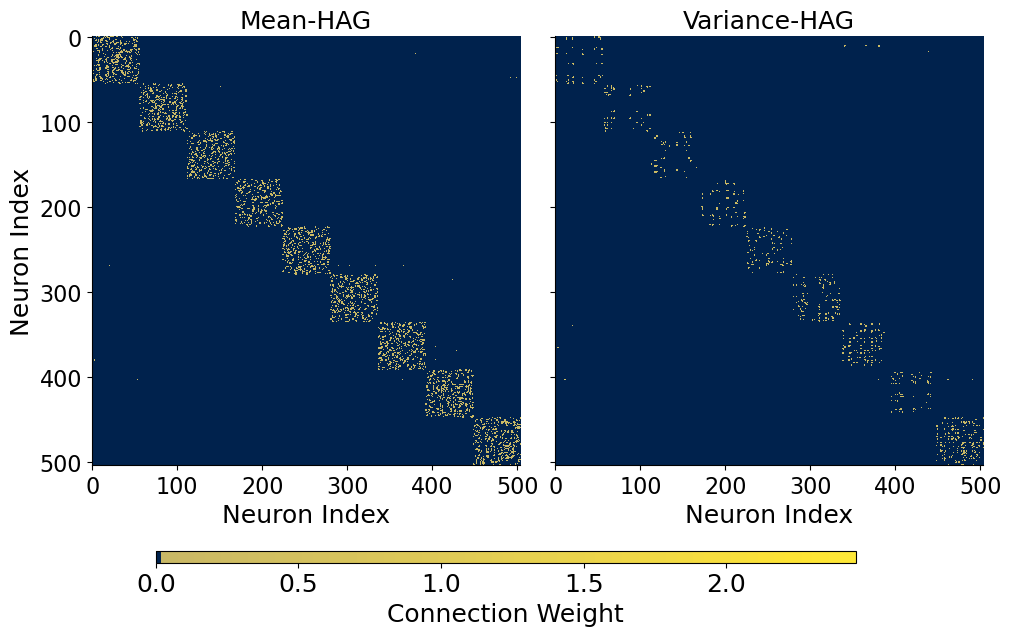

Processing dataset: Lorenz, with 2 W matrices.


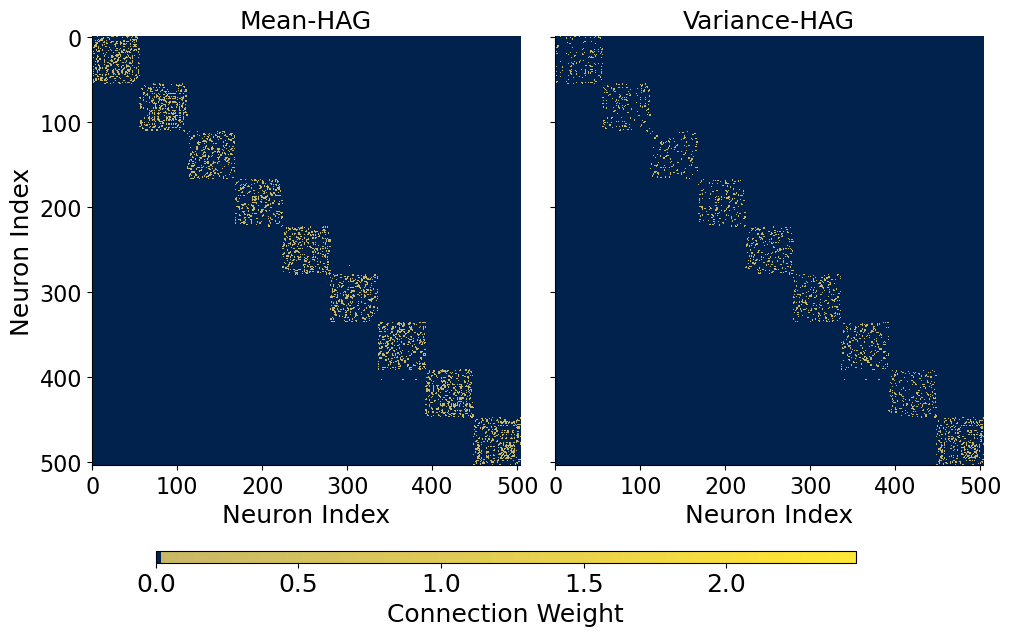

Processing dataset: Sunspot, with 2 W matrices.


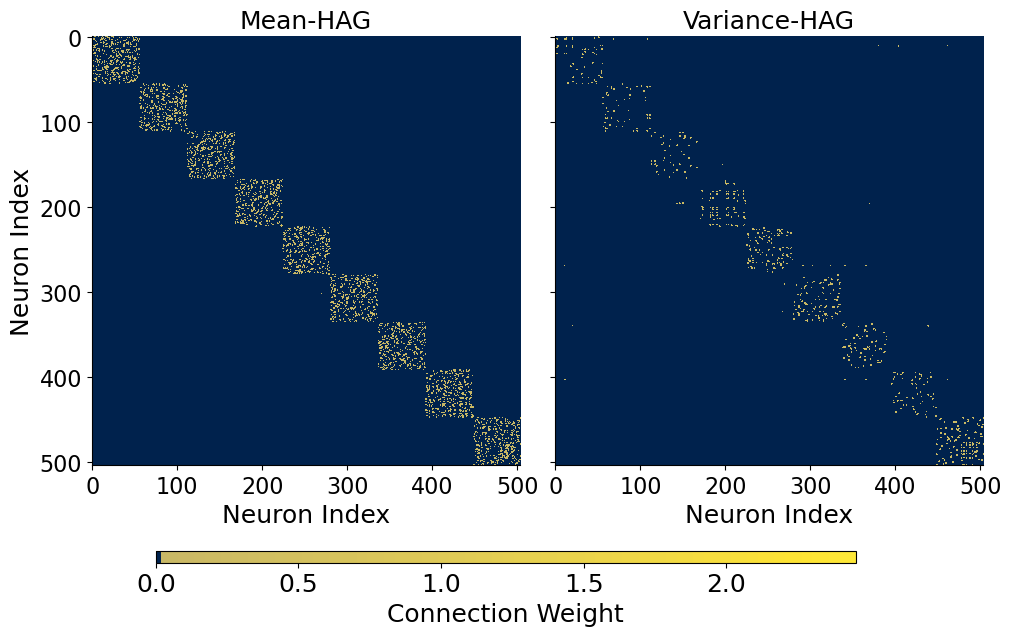

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

fontsize = 18
title_fontsize = 18  # Different size for row titles
tick_labelsize = 16  # Increasing the size of the tick labels

global_vmax = max(max_values)
if global_vmax == 0:
    global_vmax = 0.1

# Titles for columns
column_titles = ['Mean-HAG', 'Variance-HAG']

# Use a perceptually uniform colormap
colormap = plt.cm.cividis
custom_colormap = ListedColormap(np.vstack((colormap(0.0), colormap(np.linspace(0.8, 1, 128)))))

# Loop through each dataset to create a figure
for dataset_index, dataset in enumerate(datasets):
    # Select the corresponding slices of W matrices
    Ws_used = Ws[dataset_index * 2 : (dataset_index + 1) * 2]  # Adjust the slicing as per your original data structure
    print(f"Processing dataset: {dataset}, with {len(Ws_used)} W matrices.")

    # Set up the figure
    fig, axs = plt.subplots(1, len(Ws_used), figsize=(10, 6), 
                            constrained_layout=True, sharex=True, sharey=True)

    # Set titles for each subplot
    for j, ax in enumerate(axs):
        ax.set_title(column_titles[j], fontsize=title_fontsize)
        ax.set_ylabel('Neuron Index' if j == 0 else "", fontsize=fontsize)
        ax.set_xlabel('Neuron Index', fontsize=fontsize)
        
        # Increase tick label sizes
        ax.tick_params(labelsize=tick_labelsize)  # Set larger font size for tick labels

        # Plot the matrix
        heatmap = ax.imshow(Ws_used[j], cmap=custom_colormap, vmin=0, vmax=global_vmax)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Add a colorbar
    cbar_ax = fig.add_axes([0.15, -0.02, 0.7, 0.02])  # Adjusted position for visibility
    cbar = fig.colorbar(heatmap, cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label('Connection Weight', fontsize=fontsize)

    # Save and show the figure
    plt.savefig(f'connectivity_matrices_{dataset}.png', dpi=300, bbox_inches='tight')
    plt.show()